# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

##
from nilearn.connectome import sym_matrix_to_vec # outputs unique elements of a symmetric matrix

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

import pandas as pd
from math import pi
import seaborn as sns
import itertools
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from nilearn import plotting


In [3]:
#@title Figure settings
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)
subjects3 = range(5)

## Helper Functions
These functions are "modified" versions of the functions from W1D5:Dimensionality reductions. 

List of functions: Use help(_function_) to get info about each functions
* plot_variance_explained
* get_sample_cov_matrix
* sort_evals_descending
* pca
* plot_eigenvalues

In [5]:
# @title Helper Functions for __PCA__


def plot_variance_explained(variance_explained, xlimits = [0, 10]):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlim(xlimits)
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()

def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals


def plot_eigenvalues(evals, xlimits = [0, 6], limit=True ):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlim(xlimits)
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()


def get_variance_explained(evals):
  """
  Plots eigenvalues.

  Args:
    (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained

def visualize_components(component1, component2, labels, ax_labels, show=True):
  """
  1. add another dimension to the visualization
  2. fix the labels' colors + names



  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.


  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  cmap = plt.cm.get_cmap('jet')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel(ax_labels[0])
  plt.ylabel(ax_labels[1])
  plt.colorbar(ticks=range(7))
  plt.clim(-0.5, 6.5)
  if show:
    plt.show()

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [6]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [7]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [8]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [9]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

In [10]:
# region_info['myelin']

# Helper functions


## Data loading

In [11]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

## Task-based analysis

In [12]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
timeseries_rest = []
for subject in subjects:
    ts_concat = load_timeseries(subject, "rest")
    timeseries_rest.append(ts_concat)

timeseries_rest_array = np.array(timeseries_rest)

### Loading resting-state time series for a subset of subjects
To avoid issues RAM issues and testing the code, a subset of the subjects can be used.
Here, I'm loading resting state time series for 30 subjects.

In [13]:
# subjects2 = range(0, 30)
timeseries_rest = []
for subject in subjects3:
    ts_concat = load_timeseries(subject, "rest")
    timeseries_rest.append(ts_concat)

timeseries_rest_array = np.array(timeseries_rest)

## Plotting time series as heat maps

In [14]:
# For plotting sets of time courses as a heatmap
def PlotTC(X):
    
    n_nodes = timeseries_rest_array.shape[1];
    
    MAX = np.median(np.percentile(np.abs(X),95,axis=1));
    
    plt.figure(figsize=(40,80));
    plt.imshow(X,cmap='RdBu');
    plt.xlabel('Time');
    plt.ylabel('Brain region');
    plt.clim(-MAX,MAX);
    #plt.colorbar();
    #plt.xlim(t1,t2);
    
    return;




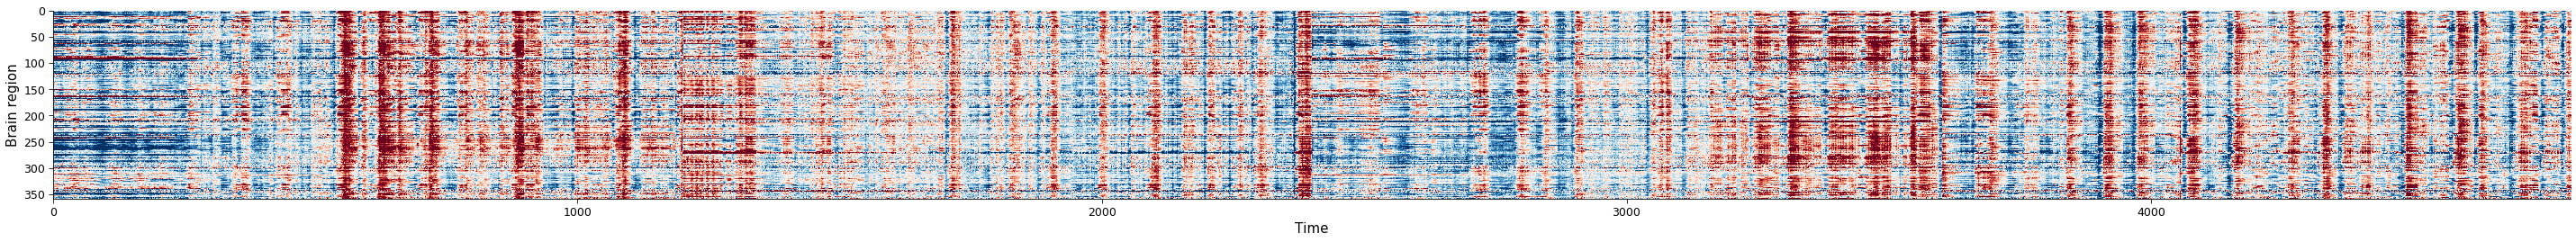

In [15]:
PlotTC(timeseries_rest_array[0])

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

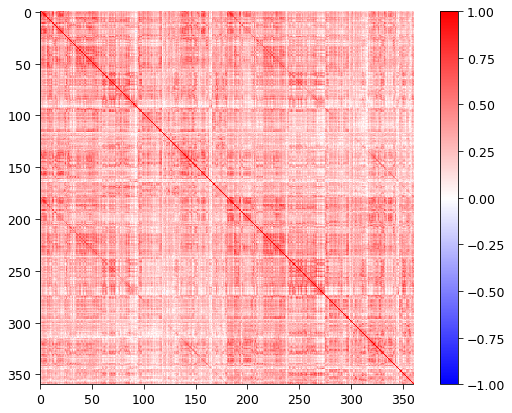

In [17]:
fc = np.zeros((5, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

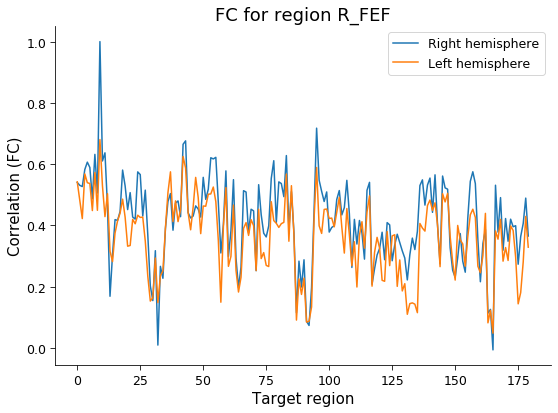

In [18]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

## Apply PCA to resting-state functional connectivity


### PCA to group level functional connectivity

In [ ]:
# 

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [21]:
timeseries_task = []
for subject in subjects3:
    timeseries_task.append(load_timeseries(subject, "motor", concat=False))

## Concatenate the time series for all the tasks and rest

In [51]:
def extract_ts(subject_ids = subjects3, 
               task_name = ["rest", "motor", "wm", "gambling", "emotion", "language", "relational", "social"],
               run = None,
               concat = False, 
               remove_mean = False):
    """
    Extract time series for the subjects and tasks
    The task time series can then be used with selective average 
    returns a dictionary with task names as keys and time series as values
    """
    ts = {}
    for task in task_name:
        ts[task] = []
        for subj in subject_ids:
            timeS = load_timeseries(subject, task, concat=concat, remove_mean = remove_mean)
            ts[task].append(timeS)
            
    return ts
        

In [52]:
ts_dict = extract_ts(concat = False)

In [53]:
ts_dict.keys()

dict_keys(['rest', 'motor', 'wm', 'gambling', 'emotion', 'language', 'relational', 'social'])

In [54]:
len(timeseries_task[0])

2

In [56]:
len(ts_dict["motor"][0])

2

## Run a simple subtraction analysis

In [57]:
task = "motor"
conditions = ["lf", "rf"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects3:

      # Get the average signal in each region for each condition
      evs = [load_evs(subject, task, cond) for cond in conditions]
#       print(len(timeseries_task[subject]))

      avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]
      # Store the region-wise difference
      contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

In [58]:
avgs[0].shape

(360,)

In [59]:
# task_dict = {'motor':['cue', 'lf', 'rf'], 
#              'wm':['0bk_body', '0bk_cor', '0bk_err', 
#                    '0bk_faces', '0bk_nlr', '0bk_places', 
#                    '0bk_tools', '2bk_body', '2bk_cor', 
#                    '2bk_err', '2bk_faces', '2bk_nlr', 
#                    '2bk_places', '2bk_tools'],
#              'gambling':['loss', 'loss_event', 'neut_event', 
#                          'win', 'win_event'], 
#              'emotion':['fear', 'neut'],
#              'language':['cue', 'math', 'present_math', 
#                          'present_story', 'question_math', 
#                          'question_story', 'response_math', 
#                          'response_story', 'story'],
#              'relational':['match', 'relation', 'error'], 
#              'social':['mental', 'mental_resp', 
#                        'other_resp', 'rnd']}


In [83]:
task_dict = {'motor':['cue', 'lf', 'rf'], 
             'wm':['0bk_body'],
             'gambling':['loss', 'loss_event', 'neut_event', 
                         'win', 'win_event'], 
             'emotion':['fear', 'neut'],
             'language':['cue', 'math', 'present_math', 
                         'present_story', 'question_math', 
                         'question_story', 'response_math', 
                         'response_story', 'story'],
             'relational':['match', 'relation', 'error'], 
             'social':['mental', 'mental_resp', 
                       'other_resp', 'rnd']}


In [84]:
def extract_ts_ev(task_dict, 
                  ts_dict,
                  subject_ids = subjects3, 
                  task_name = ["motor", "wm", "gambling", "emotion", "language", "relational", "social"], 
                  ):
    """
    taskes in the task dictionary and returns the averaged
    time series for each condition of the task in a dictionary
    """
    ts_ev = {}
    for task in task_name:
        print(task)
        for subject in subject_ids:
            conditions = task_dict[task]
            evs = [load_evs(subject, task, cond) for cond in conditions]
            avgs = [selective_average(ts_dict[task][subject], ev) for ev in evs]
            ts_ev[task] = avgs
            
    return ts_ev

In [85]:
a = extract_ts_ev(task_dict, ts_dict, task_name = ["motor", "wm"])

motor
wm


TypeError: zip argument #1 must support iteration

Plot group-averaged contrast value across regions:

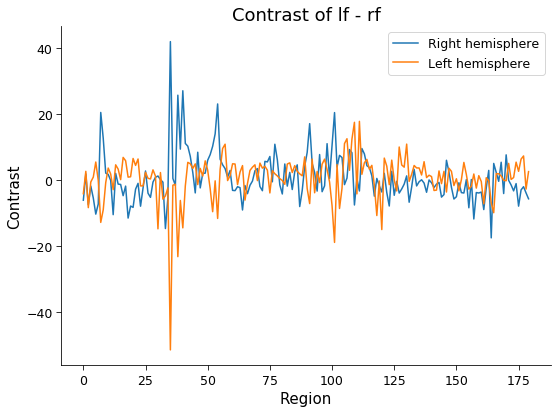

In [29]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

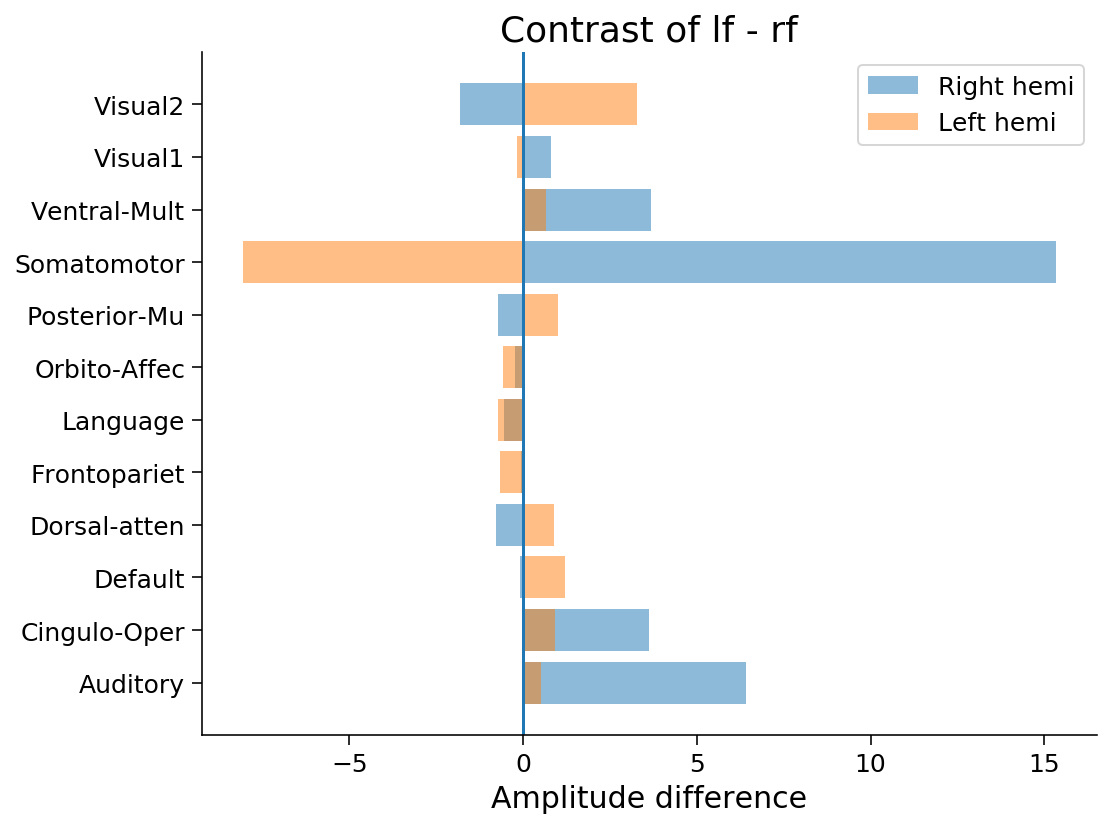

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

## Loading task time series for all the subjects
Time series for all the tasks (runs concatenated) will be loaded for all the subjects.
The same can be done for a subsest of subjects

In [ ]:
task_names = ["motor", "wm", "gambling", "emotion", "language", "relational", "social"]
 
FC_subjects = np.zeros((339, 7, 360, 360))
flatten = np.zeros((339, 7, 360*360))
FC_subjects_upper = np.zeros((339, 7, 64980))

for subject in subjects:
  # print(f"subject id is {subject}")
  ti = 0;
  for task in tasks_names:
    # print(f"task is {task}")
    tmp = load_timeseries(subject,task, concat = True)
    # print(tmp.shape)
    # print(np.corrcoef(tmp).shape)
    FC_subjects[subject, ti, :, :] = np.corrcoef(tmp)
    #flatten[subject, ti, :] = np.matrix.flatten(FC_subjects[subject, ti, :, :])
    #FC_subjects_upper[subject, ti, :]  = flatten[subject, ti, 0:64800]
    FC_subjects_upper[subject, ti, :] = sym_matrix_to_vec(FC_subjects[subject, ti, :, :])
    
    ti = ti+1

FC_subjects_upper.shape

In [17]:
task_names = ["motor", "wm", "gambling", "emotion", "language", "relational", "social"]
 
FC_subjects2 = np.zeros((N_SUBJECTS2, len(task_names), 360, 360))
FC_subjects_upper2 = np.zeros((N_SUBJECTS2, 7, 64980))

for subject in subjects2:
  # print(f"subject id is {subject}")
    ti = 0
    for task in task_names:
        tmp = load_timeseries(subject,task, concat = True)
    # print(tmp.shape)
    # print(np.corrcoef(tmp).shape)
    FC_subjects2[subject, ti, :, :] = np.corrcoef(tmp)
    #flatten[subject, ti, :] = np.matrix.flatten(FC_subjects[subject, ti, :, :])
    #FC_subjects_upper[subject, ti, :]  = flatten[subject, ti, 0:64800]
    FC_subjects_upper2[subject, ti, :] = sym_matrix_to_vec(FC_subjects2[subject, ti, :, :])
    
    ti = ti+1

FC_subjects_upper2.shape

(30, 7, 64980)

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [18]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

(339, 25)

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]


# PROJECT
__Phenomena__: The relationship between functional connectivity in resting state and task performance.

__Question__: Are we able to make reliable predictions of one (task/rest) using the other?

__Hypothesis1__: Prediction error differs across tasks when using resting state functional connectivity.

## Exploring the data
Here, we will be just exploring the data mostly in terms of the number of subjects, number of time points, ...

In [ ]:
timeseries = load_timeseries(subject=0, name="rest", runs=4, concat = True)
print(timeseries.shape)  # n_parcel x n_timepoint

(360, 284)


In [ ]:
timeseries_task_0 = load_timeseries(subjects[0],"relational", concat = True)
timeseries_task_0.shape

(360, 464)

### 1. Exploring the data
Here, for each subject and each task, the concatenated time series is loaded and the functional connectivity will be calculated. All the functional connectivity matrices for all the subjects and all the tasks will be stored in a numpy array called _FC_subjects_ with dimensions [# subjects, # tasks, # parcels, # parcels]

#### 1.1 Working with the group average functional connectivity matrices
Here, the average functional connectivity is calculated across subjects

Things to do:

1. re-arrange the matrix with subjects as rows and FCs of the parcels as columns
2. apply PCA to matrix from 1
3. applying PCA to the data for each task separately
4. Try applying tSNE?! + visualize the results
** WHAT IS THE NEXT STEP?!


In [ ]:
group_FC = np.mean(FC_subjects, axis = 0)
group_FC.shape

(7, 360, 360)

#### 1.2 Projecting the 2D functional connectivity matrix into 1 dimension
Here, the functional connectivity for each parcel is averaged, showing the average strength of functional connectivity of each parcel

In [ ]:
mean_group_FC = np.mean(group_FC, axis = 1)
mean_group_FC.shape

(7, 360)

#### 1.3 Applying PCA to the projected group average functional connectivity
This is mostly done for visualization and some data exploration to see where tasks fall in each component
##### 1.3.1 Using user-defined pca function
This is basically just a practice. We will be playing around with variance explained and scree plots

In [ ]:
score, evectors, evals = pca(mean_group_FC)
print(score.shape)
print(evectors.shape)
print(evals.shape)

(7, 360)
(360, 360)
(360,)


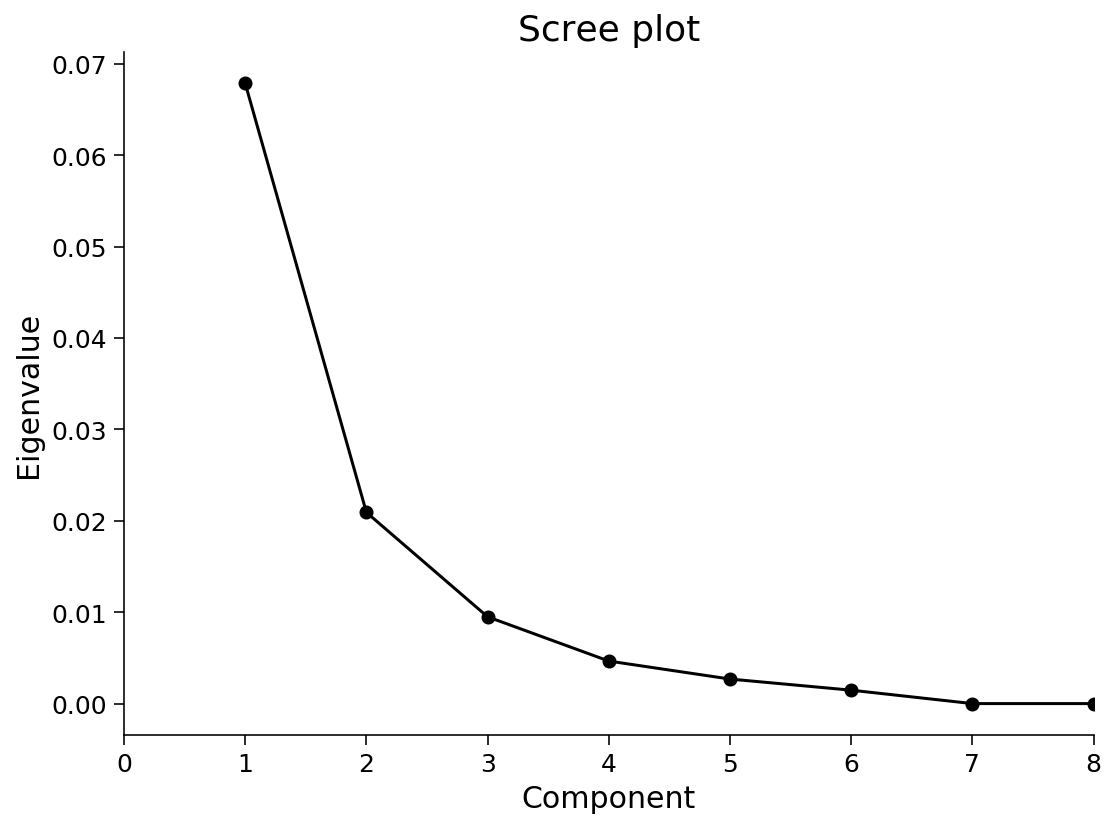

In [ ]:
# scree plot
plot_eigenvalues(evals, xlimits = [0, 8])

_Figure 1_. Scree plot showing the eigenvalues vs. component number. It can be seen that the eigen values drop to zero after 6.

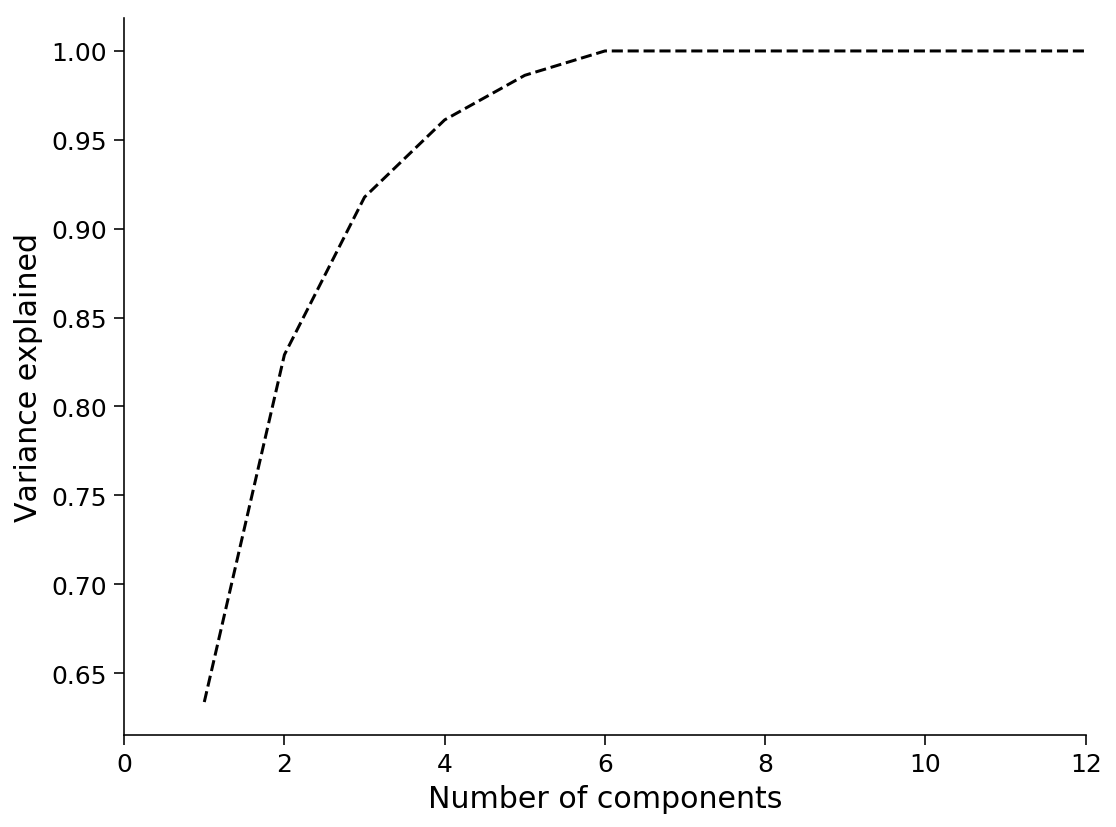

In [ ]:
# calculate the variance explained
variance_explained = get_variance_explained(evals)
plot_variance_explained(variance_explained, xlimits = [0, 12])

_Figure 2_. Cumulative variance explained by the components. From the plot it can be seen that 4 components would be enough to be able to explain 95% of the variance.

##### 1.3.2 Using sklearn's PCA
Here, we will be using sklearn's PCA.

sklearn's PCA does not automatically zero-mean the variables, so we need to import the StandardScalar as well!

In [ ]:
X_standard = StandardScaler(with_std = False).fit(mean_group_FC)
Xs = X_standard.fit_transform(mean_group_FC)

# setting the PCA to return enough number of components so that we are able to explain 95% of the variance in the data
model1 = PCA(n_components = 0.95)
PCs = model1.fit_transform(Xs)

PCs.shape

(7, 4)

In [ ]:
# printing out the task names before visualizations
tasks_names

['motor', 'wm', 'gambling', 'emotion', 'language', 'relational', 'social']

/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


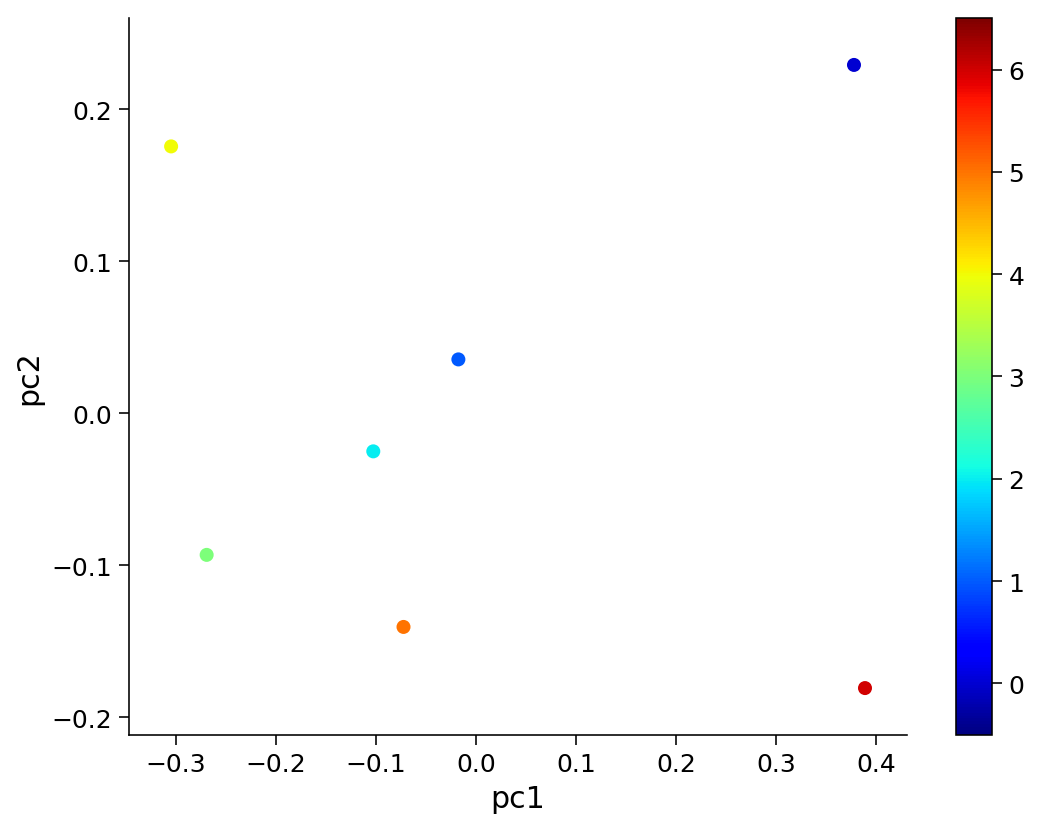

In [ ]:
visualize_components(PCs[:, 0], PCs[:, 1], [0, 1, 2, 3, 4, 5, 6], ['pc1', 'pc2'], show=True)

_Figure 3_. Plotting component loadings for the second component vs the first component. Data points are colored according to tasks. From the plot, two data points seem to be standing out: the data point representing task id 0 (motor task) and 6 (social task) are indistingushable using pc1, but using pc2 the difference between the two tasks is HUGE! This is also the case for tasks 3 and 4. One take-away from this figure: Although the first component is the component explaining the most variance 

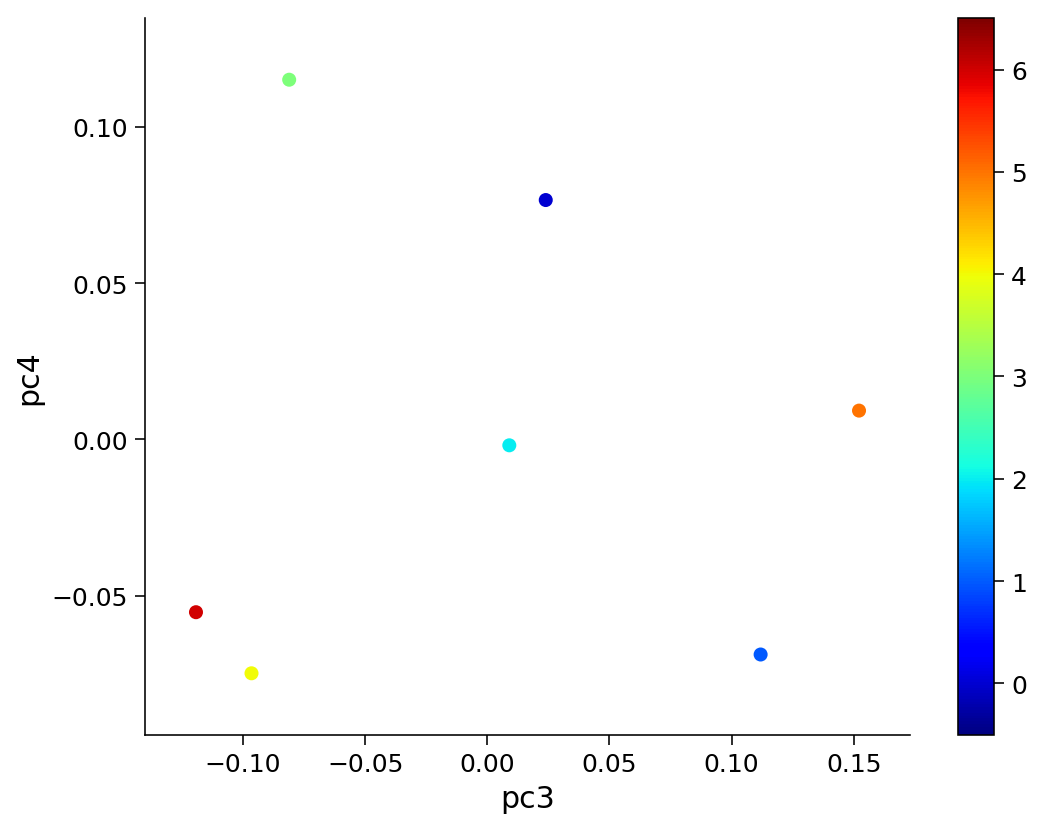

In [ ]:
visualize_components(PCs[:, 2], PCs[:, 3], [0, 1, 2, 3, 4, 5, 6], ['pc3', 'pc4'], show=True)

_Figure 4_. Plotting component loadings for the fourth component vs the third component

In [ ]:
group_FC

(7, 360, 360)

#### 1.4. Apply PCA to functional connectivity matrix of each task separately
What is the number of PCs needed to retain 95% of the variance in the data for each task?

In [ ]:
componentsXtask = []
variance_explained = 0.95

for task in range(7):
    X_standard = StandardScaler(with_std = False).fit(group_FC[task,:,:])
    Xs = X_standard.fit_transform(group_FC[task,:,:])
    model1 = PCA(n_components = variance_explained)
    PCs = model1.fit_transform(Xs)
    componentsXtask.append(PCs.shape[1])
    

/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


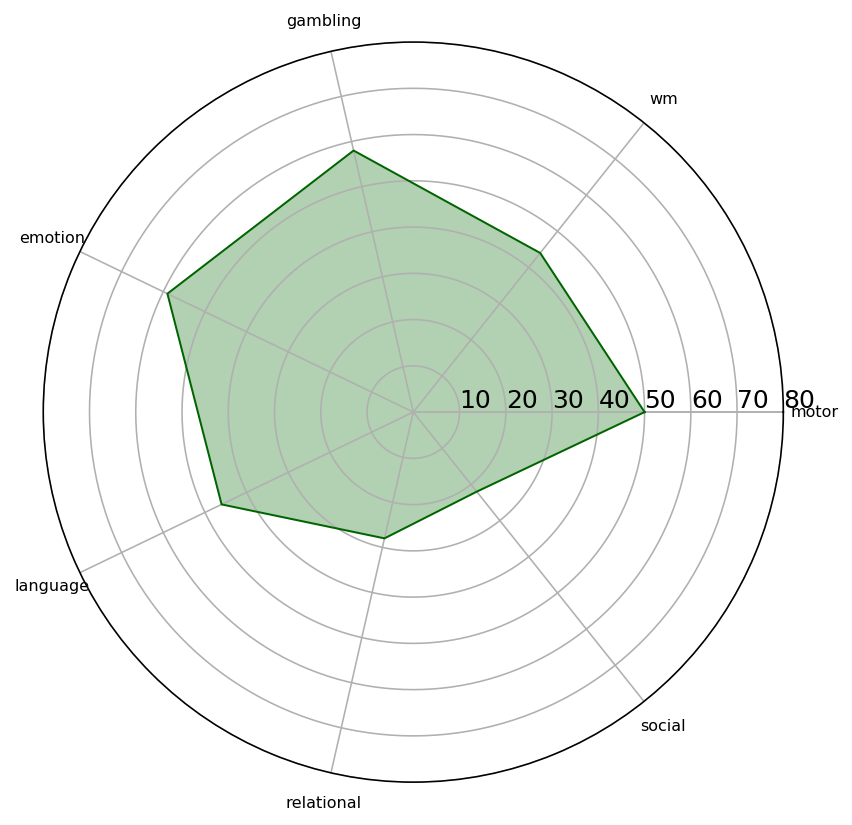

In [ ]:
Net = tasks_names
values = componentsXtask
values += values[:1]
N = len(Net)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles, Net, color='black', size=8)

# Draw ylabels
ax.set_rlabel_position(0)
#plt.yticks([0,20, 40, 60, 80 ,100], ["0","20", "40", "60", "80","100"], color="grey", size=7)
#plt.yticks([0,5, 10, 15, 20 ,25, 30], ["0","5", "10", "15", "20","25","30"], color="grey", size=8)

plt.ylim(0,80)

# Plot data
ax.plot(angles, values, 'darkgreen', linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values, 'darkgreen', alpha=0.3)
plt.show()

#### 1.5. Apply PCA to functional connectivity matrix of each task separately
Here, the question is: Which regions are more "important" for each tasks and for rest?


##### 1.5.1 Apply PCA to functional connectivity matrix of each task

In [40]:
FC_subjects2.shape

(30, 7, 360, 360)

In [19]:
tasks=[0, 1, 2, 3, 4, 5, 6]
# FC_subjects2
# all_sub_task = np.zeros((N_SUBJECTS2, 360, 7))
for subject in subjects2:
    for task in tasks:
        X_standard = StandardScaler(with_std = False).fit(FC_subjects2[subject, task,:,:])
        Xs = X_standard.fit_transform(FC_subjects2[subject, task,:,:])
        # setting the PCA to return enough number of components so that we are able to explain 95% of the variance in the data
        model2 = PCA(n_components = 0.95)
        PCs =model2.fit(Xs)
        

/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_varianc

/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_varianc

/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_varianc

/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_varianc

/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/ladan/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:447: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_varianc

In [22]:
tasks=[0, 1, 2, 3, 4, 5, 6]
# FC_subjects2
# all_sub_task = np.zeros((N_SUBJECTS2, 360, 7))
for subject in subjects2:
        X_standard = StandardScaler(with_std = False).fit(fc2[subject,:,:])
        Xs = X_standard.fit_transform(fc2[subject,:,:])
        # setting the PCA to return enough number of components so that we are able to explain 95% of the variance in the data
        model2 = PCA(n_components = 0.95)
        PCs =model2.fit(Xs)
        

In [20]:
PCs.components_.shape

(1, 360)

In [ ]:
sbj2plot = 0
task2plot = 0

fig = plt.subplots(1,figsize=(7,5))

plt.subplot(211)
plt.plot(all_sub_task_raws[sbj2plot,:,task2plot],'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$')
plt.title('Raw singular values')

plt.subplot(212)
plt.plot(all_sub_task[sbj2plot,:,task2plot],'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$ (% of total)')
plt.title('Percent-change-normalized singular values')

plt.tight_layout()
plt.show()

/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


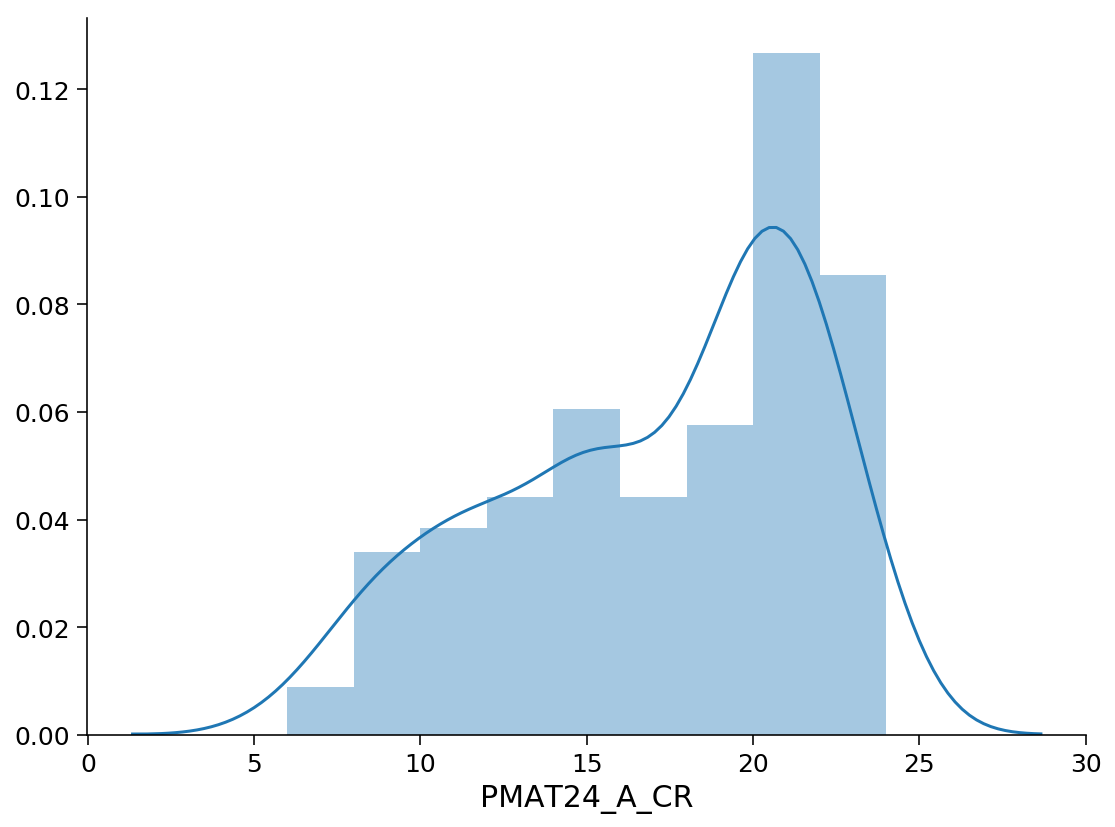

In [ ]:
behavioural_data = pd.read_csv('filtered_behavioural.csv', sep=';')

behav = 'PMAT24_A_CR'

behavioural_data[behav].fillna((behavioural_data[behav].mean()), inplace=True)


sns.distplot(behavioural_data[behav])
plt.show()



In [ ]:
wm_column = [col for col in behavioural_data if col.startswith('WM')]

In [ ]:
def dynamic_FC(sbj_ts_rest_array, time_window, sliding):
    frame = np.arange(0, timeseries_rest_array.shape[2], step=sliding)
    correlation_matrix = []
    for ts in frame:
        correlation_coeff = np.corrcoef(sbj_ts_rest_array[:,ts:ts+time_window])
        correlation_matrix.append(correlation_coeff)
    correlation_matrix = np.array(correlation_matrix)
    
    return correlation_matrix

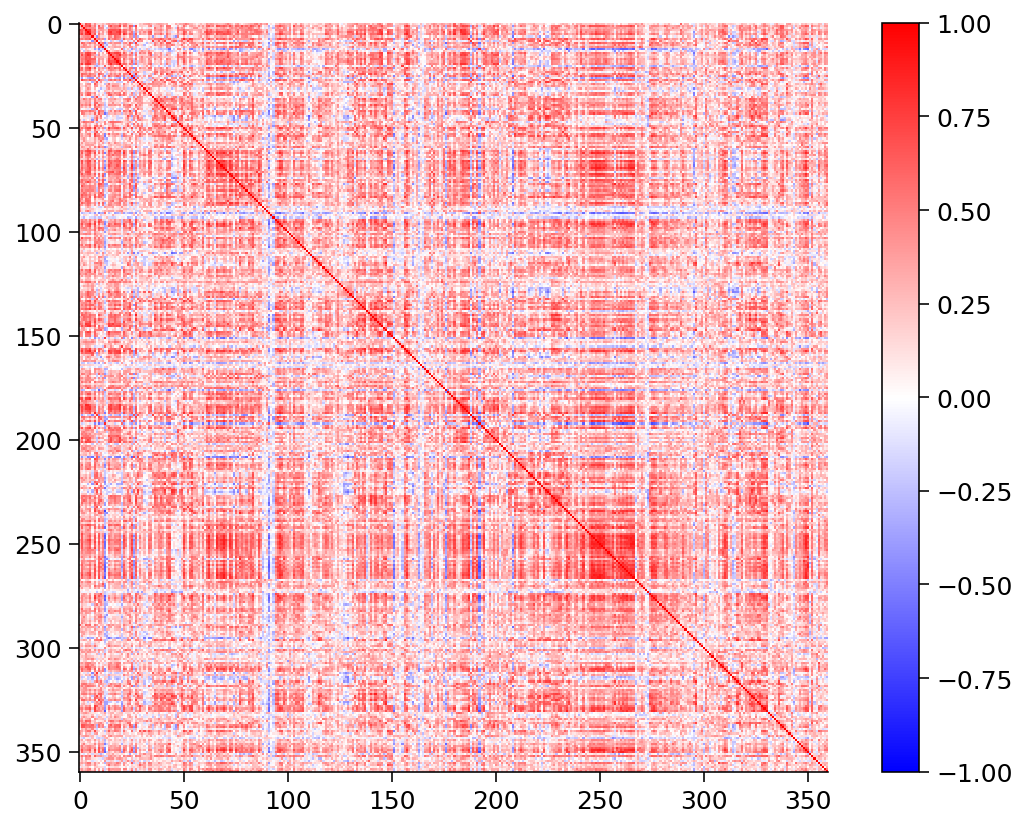

In [ ]:
dynamic = dynamic_FC(timeseries_rest_array[0], 50, 10)

plt.imshow(dynamic[0], interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
def refresh(window=3):
    plt.imshow(dynamic[int(window)], interpolation="none", cmap="bwr", vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()
    
style = {'description_width': 'initial'}

_ = widgets.interact(refresh, 
    window=widgets.FloatSlider(value=3, min=0, max=dynamic.shape[0], step=1, description="window", style=style),
)  
  
    

interactive(children=(FloatSlider(value=3.0, description='window', max=480.0, step=1.0, style=SliderStyle(desc…

/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


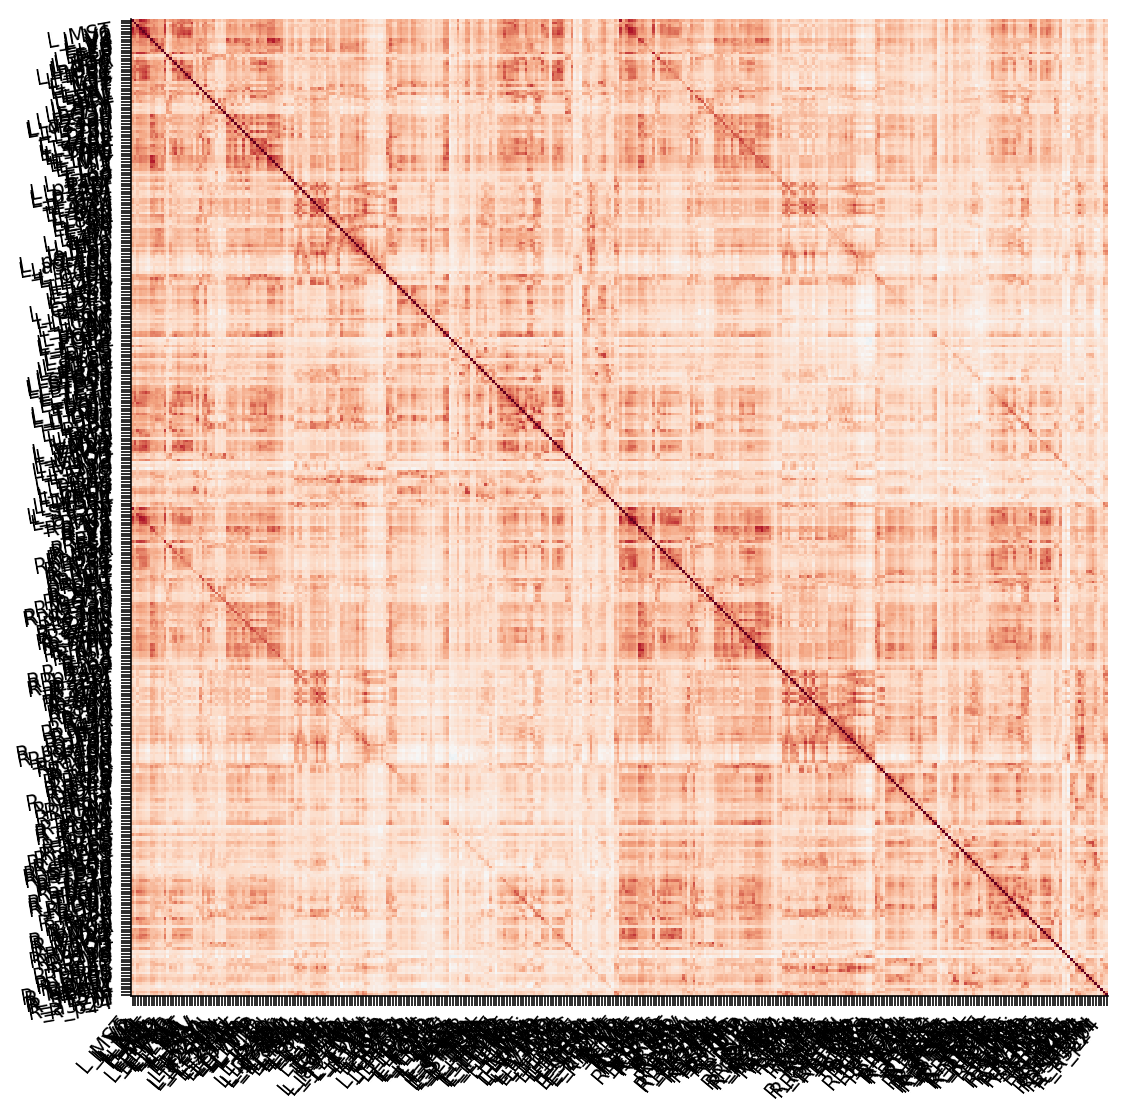

In [ ]:

labels = open("HCPMMP1_on_MNI152_ICBM2009a_nlin.txt", "r")
labels = labels.read().split('\n')



plotting.plot_matrix(group_fc, figure=(10, 8), labels=labels[1:],
                     vmax=1.0, vmin=-1.0, reorder=False, colorbar=False)



/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


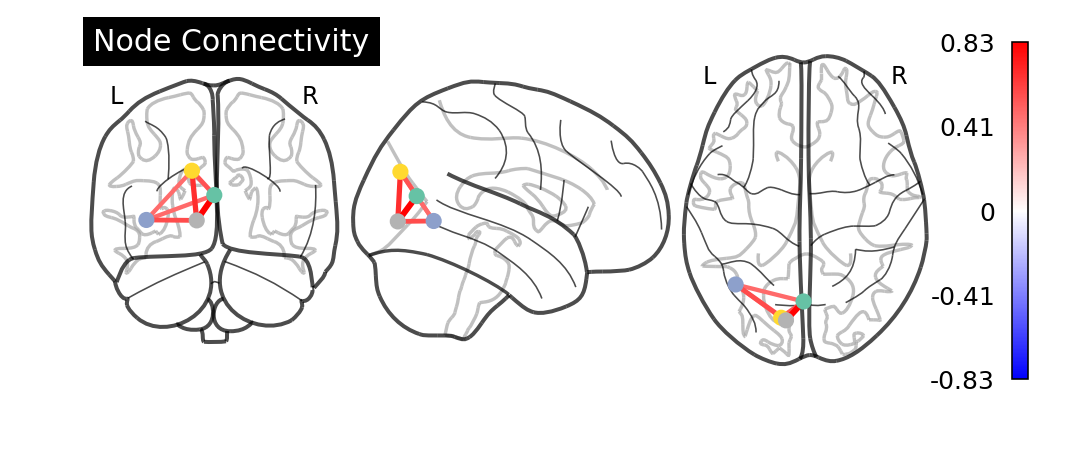

In [ ]:
coordinates = pd.read_excel('Glasser_coordinates.xlsx', header=None)
coordinates = np.array(coordinates)

node2plot =  [coordinates[0], coordinates[1], coordinates[2], coordinates[3]]

plotting.plot_connectome(group_fc[0:4,0:4], node2plot, colorbar=True,
                         title="Node Connectivity")

In [ ]:
tasks_names

['motor', 'wm', 'gambling', 'emotion', 'language', 'relational', 'social']

## Defining CPM

Finn ES, Shen X, Scheinost D, Rosenberg MD, Huang J, Chun MM, Papademetris X, Constable RT. (2015) Functional connectome fingerprinting: Identifying individuals using patterns of brain connectivity. Nature Neuroscience, 18: 1664–1671. 

## 2. Here we create a model to predict behaviour/Task-evoked activity

/home/davide/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


X shape is (339, 64980)
y shape is (339,)


/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


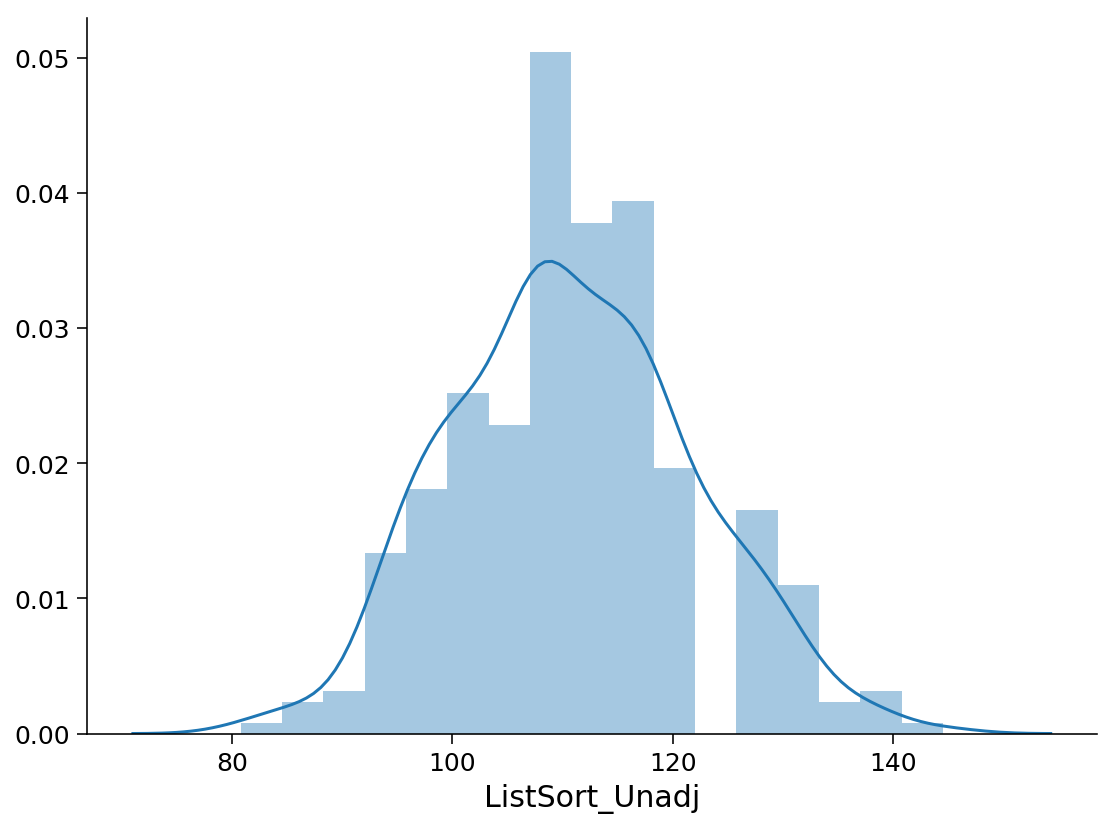

In [ ]:
X = FC_subjects_upper[:, 1, :]

behav = 'ListSort_Unadj' #Working Memory task

y = behavioural_data[behav]

sns.distplot(behavioural_data[behav])

print(f"X shape is {X.shape}")
print(f"y shape is {y.shape}")

Fixed bugged behavioural values

In [ ]:
def fixed_bugged_column(df, column):
    df[column] = df[column].apply(lambda x: float(x.split()[0].replace(',', ''))) 
    for lines in range(len(df[column])): 
        if df[column][lines]>100:  
            df[column][lines]=df[column][lines] / 10**(len(str(df[column][lines])) - 4)    
    for lines in range(len(df[column])):  
          if df[column][lines]>100:
                df[column][lines]=df[column][lines] / 10**(len(str(df[column][lines])) - 4)  

/home/davide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/davide/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


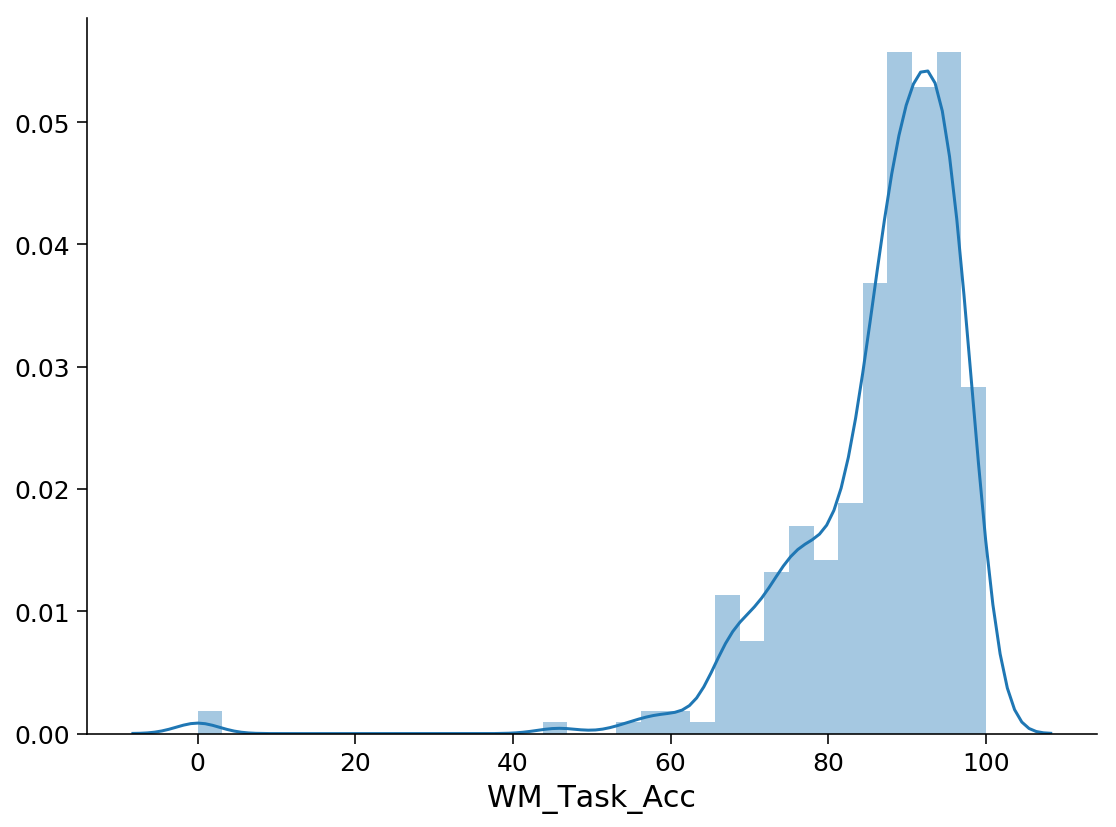

In [ ]:
df = pd.read_csv('filtered_behavioural.csv', sep=';') 

fixed_bugged_column(df, 'WM_Task_Acc')

sns.distplot(df['WM_Task_Acc']) 

In [ ]:
model_ridge = RidgeCV(alphas = [1e-2, 1e-1, 1, 10, 20, 25, 100], normalize = True, fit_intercept = False,
                      gcv_mode = 'auto', store_cv_values = True, scoring = 'r2')
model_ridge.fit(X, y)

RidgeCV(alphas=array([1.0e-02, 1.0e-01, 1.0e+00, 1.0e+01, 2.0e+01, 2.5e+01, 1.0e+02]),
    cv=None, fit_intercept=False, gcv_mode='auto', normalize=True,
    scoring='r2', store_cv_values=True)

In [ ]:
model_ridge.score(X, y)

0.9999999997863767

/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


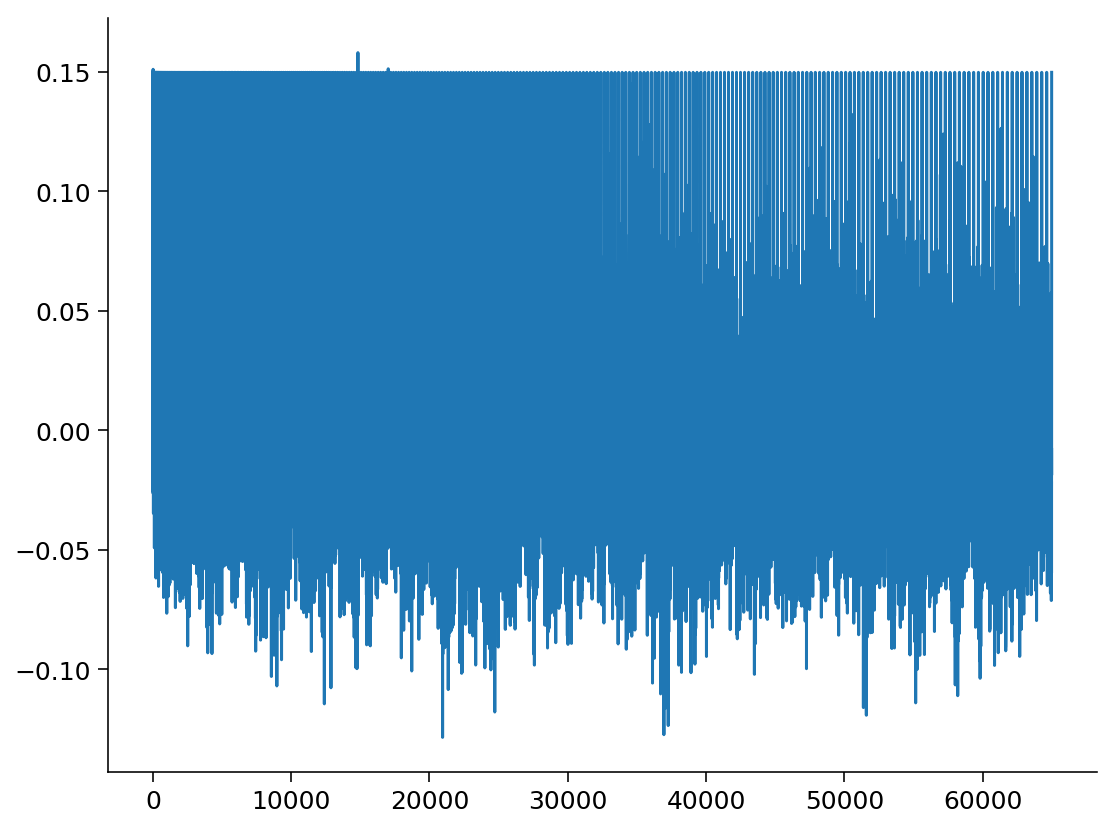

In [ ]:
plt.plot(model_ridge.coef_)

In [ ]:
model_lasso = LassoCV(alphas = [1e-3, 1e-1, 1, 10, 20, 25, 100], fit_intercept = False, 
                     cv = 10)
model_lasso.fit(X, y)

/home/davide/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/davide/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/davide/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/davide/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

LassoCV(alphas=[0.001, 0.1, 1, 10, 20, 25, 100], copy_X=True, cv=10,
    eps=0.001, fit_intercept=False, max_iter=1000, n_alphas=100,
    n_jobs=None, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

/home/davide/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


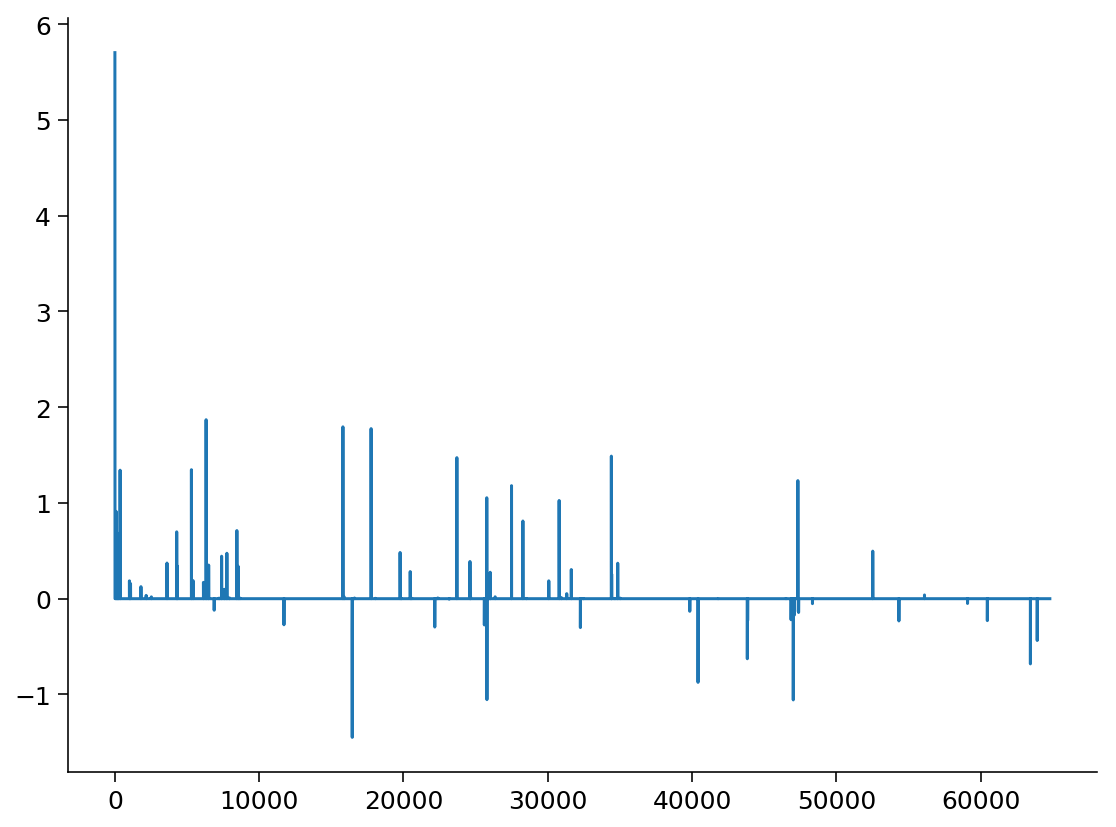

In [ ]:
plt.plot(model_lasso.coef_)

In [ ]:
model_lasso.score(X, y)

0.38680366048493087

In [ ]:
# applying PCA
X_standard = StandardScaler(with_std = False).fit(X)
Xs = X_standard.fit_transform(X)

model_pca = PCA(n_components = 0.95)
PCs = model_pca.fit_transform(X)

PCs.shape

(339, 257)

In [ ]:
model_ridge1 = RidgeCV(alphas = [1e-3, 1e-1, 10, 20, 25, 100], normalize = True, fit_intercept = False, 
                      cv = 10, gcv_mode = 'auto', scoring = 'r2')
model_ridge1.fit(PCs, y)

/home/davide/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.0e-03, 1.0e-01, 1.0e+01, 2.0e+01, 2.5e+01, 1.0e+02]),
    cv=10, fit_intercept=False, gcv_mode='auto', normalize=True,
    scoring='r2', store_cv_values=False)

In [ ]:
model_ridge1.score(PCs, y)

-101.32829910936442

## Predicting resting state functional connectivity from task FC - group level

In [ ]:
rest_group_fc_vec = sym_matrix_to_vec(group_fc)
rest_group_fc_vec.shape

(64980,)

In [ ]:
task_group_fc = FC_subjects.mean(axis = 0)
task_group_fc_vec = np.zeros((64980, 7))
for ts in [0, 1, 2, 3, 4, 5, 6]:
    task_group_fc_vec[:, ts] = sym_matrix_to_vec(task_group_fc[ts, :, :])
    

In [ ]:
task_group_fc_vec.shape

(64980, 7)

In [ ]:
tr_model_ridge = RidgeCV(alphas = [0.001, 0.1, 10, 100], fit_intercept = False, normalize = True, 
                        scoring = 'r2', cv = 10)
tr_model_ridge.fit(task_group_fc_vec, rest_group_fc_vec)

RidgeCV(alphas=array([1.e-03, 1.e-01, 1.e+01, 1.e+02]), cv=10,
    fit_intercept=False, gcv_mode=None, normalize=True, scoring='r2',
    store_cv_values=False)

In [ ]:
tr_model_ridge.score(task_group_fc_vec, rest_group_fc_vec)

0.8536247982539461

In [ ]:
#tr_model_ridge.store_cv_values()

In [ ]:
task_ids = [0, 1, 2, 3, 4, 5, 6]
R2_array =[]
for ids in task_ids:
    model_ridge = RidgeCV(alphas = [0.001, 0.1, 10, 100], fit_intercept =False, normalize = True, 
                         scoring = 'r2', cv = 10)
    model_ridge.fit(task_group_fc_vec[:, ids].reshape(-1, 1), rest_group_fc_vec)
    R2_array.append(model_ridge.score(task_group_fc_vec[:, ids], rest_group_fc_vec))
    
    
    

# Running ridge regressions where we are progressively removing tasks from the predictors
# This model is using six tasks

In [ ]:
tr_model_ridge = RidgeCV(alphas = [0.001, 0.1, 10, 100], fit_intercept = False, normalize = True, 
                        scoring = 'r2', cv = 10)
tr_model_ridge.fit(task_group_fc_vec[:,0:5], rest_group_fc_vec)

RidgeCV(alphas=array([1.e-03, 1.e-01, 1.e+01, 1.e+02]), cv=10,
    fit_intercept=False, gcv_mode=None, normalize=True, scoring='r2',
    store_cv_values=False)

In [ ]:
tr_model_ridge.score(task_group_fc_vec[:,0:5], rest_group_fc_vec)

0.8437171212452047

## Stepwise regression
iteratively removing tasks as regressors and examining differen models (different combinations of tasks)

In [ ]:

combination = []
stuff = [0, 1, 2, 3, 4, 5, 6]
for L in range(0, len(stuff)+1):
    
    for subset in itertools.combinations(stuff, L):
        combination.append(subset)
        
combination = np.array(combination)

In [ ]:
all_model_scores = []
for model in range(8,combination.shape[0]):
    tr_model_ridge = RidgeCV(alphas = [0.001, 0.1, 10, 100], fit_intercept = False, normalize = True, 
                        scoring = 'r2', cv = 10)
    tr_model_ridge.fit(task_group_fc_vec[:,combination[model]], rest_group_fc_vec)
    all_model_scores.append(tr_model_ridge.score(task_group_fc_vec[:,combination[model]], rest_group_fc_vec))
                                         
all_model_scores = np.array(all_model_scores)

In [ ]:
df_all_model_scores = pd.DataFrame(data=all_model_scores, index=combination[8:combination.shape[0]])

In [ ]:
%matplotlib
fig = plt.figure(figsize = (50, 20))
bar = sns.barplot(x = df_all_model_scores.index, y = 0, data=df_all_model_scores)
bar.set_xticklabels(labels = combination[8:combination.shape[0]], rotation = 45)
#plt.rcParams["xtick.labelsize"] = 7

Using matplotlib backend: Qt5Agg


[Text(0, 0, '(0, 1)'),
 Text(0, 0, '(0, 2)'),
 Text(0, 0, '(0, 3)'),
 Text(0, 0, '(0, 4)'),
 Text(0, 0, '(0, 5)'),
 Text(0, 0, '(0, 6)'),
 Text(0, 0, '(1, 2)'),
 Text(0, 0, '(1, 3)'),
 Text(0, 0, '(1, 4)'),
 Text(0, 0, '(1, 5)'),
 Text(0, 0, '(1, 6)'),
 Text(0, 0, '(2, 3)'),
 Text(0, 0, '(2, 4)'),
 Text(0, 0, '(2, 5)'),
 Text(0, 0, '(2, 6)'),
 Text(0, 0, '(3, 4)'),
 Text(0, 0, '(3, 5)'),
 Text(0, 0, '(3, 6)'),
 Text(0, 0, '(4, 5)'),
 Text(0, 0, '(4, 6)'),
 Text(0, 0, '(5, 6)'),
 Text(0, 0, '(0, 1, 2)'),
 Text(0, 0, '(0, 1, 3)'),
 Text(0, 0, '(0, 1, 4)'),
 Text(0, 0, '(0, 1, 5)'),
 Text(0, 0, '(0, 1, 6)'),
 Text(0, 0, '(0, 2, 3)'),
 Text(0, 0, '(0, 2, 4)'),
 Text(0, 0, '(0, 2, 5)'),
 Text(0, 0, '(0, 2, 6)'),
 Text(0, 0, '(0, 3, 4)'),
 Text(0, 0, '(0, 3, 5)'),
 Text(0, 0, '(0, 3, 6)'),
 Text(0, 0, '(0, 4, 5)'),
 Text(0, 0, '(0, 4, 6)'),
 Text(0, 0, '(0, 5, 6)'),
 Text(0, 0, '(1, 2, 3)'),
 Text(0, 0, '(1, 2, 4)'),
 Text(0, 0, '(1, 2, 5)'),
 Text(0, 0, '(1, 2, 6)'),
 Text(0, 0, '(1, 3, 4)'

In [ ]:
tasks_names

['motor', 'wm', 'gambling', 'emotion', 'language', 'relational', 'social']